# Risk Adjustment
In this notebook we risk adjusted readmission rate for each hospital. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

Using TensorFlow backend.


## Risk Adjustment for LME

In [58]:
cohort = 'ami'

In [130]:
adjust_df = pd.read_csv(path+'cohorts/'+cohort+'/adjustment_tst0.csv')

In [124]:
adjust_df.head()

,Unnamed: 0,KEY_NRD,HOSP_NRD,readm30,predicted_score,expected_score
0,1,21012648,12307,0,0.051148,0.051148
1,2,16083400,12298,0,0.042033,0.042033
2,3,19388490,12470,0,0.119920,0.119920
3,4,23046598,12793,0,0.124286,0.124286
4,5,15105464,11292,0,0.089153,0.089153


In [131]:
national_rate = adjust_df.readm30.mean()

In [132]:
grouped = adjust_df.groupby('HOSP_NRD')

adjusted_rate = grouped[['readm30', 'predicted_score', 'expected_score']].mean()

adjusted_rate = adjusted_rate.assign(N=grouped.size())

adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'N']

adjusted_rate = adjusted_rate.assign(Adjusted_ME=adjusted_rate.Predicted_ME/adjusted_rate.Expected_ME*national_rate)

In [64]:
adjusted_rate = adjusted_rate.sort_values(by='N', ascending=False)

In [126]:
national_rate

0.12522119288019154

In [12]:
recycle_ME = pd.read_csv(path+'cohorts/{}/recycled_ME.csv'.format(cohort))

In [14]:
adjusted_rate = pd.merge(adjusted_rate, recycle_ME, on='HOSP_NRD')

In [133]:
adjusted_rate.head(10)

,Observed,Predicted_ME,Expected_ME,N,Adjusted_ME
HOSP_NRD,,,,,
11006,0.117647,0.102501,0.114676,17,0.111927
11010,0.071429,0.097250,0.109738,42,0.110971
11011,0.142857,0.187105,0.216036,7,0.108452
11013,0.177778,0.187278,0.144142,45,0.162695
11014,0.065574,0.113944,0.123901,61,0.115157
11021,0.088235,0.073811,0.099660,34,0.092742
11022,0.085714,0.104423,0.105806,35,0.123585
11024,0.250000,0.297538,0.290223,4,0.128377
11029,0.086957,0.155237,0.145367,23,0.133723


In [134]:
adjusted_rate = adjusted_rate.reset_index()

In [85]:
intercept = pd.read_csv(path+'cohorts/{}/intercepts0.csv'.format(cohort))

In [87]:
intercept.columns = ['HOSP_NRD', 'intercept', 'AGE']

In [122]:
adjusted_rate0 = adjusted_rate.copy()

In [155]:
compare = pd.merge(adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], intercept[['HOSP_NRD', 'intercept']], on='HOSP_NRD')

In [135]:
compare = pd.merge(adjusted_rate0[['HOSP_NRD', 'Adjusted_ME', 'N']], adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], on='HOSP_NRD', 
                   suffixes=('_index', '_tst'))

In [136]:
compare.head()

,HOSP_NRD,Adjusted_ME_index,N,Adjusted_ME_tst
0,11006,0.113181,177,0.111927
1,11010,0.112333,416,0.110971
2,11011,0.109424,71,0.108452
3,11013,0.164535,459,0.162695
4,11014,0.116193,617,0.115157


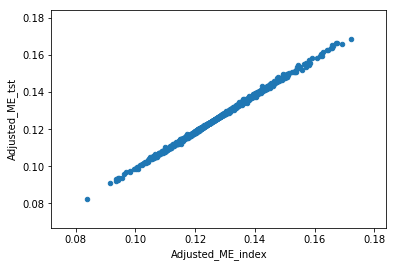

In [137]:
compare.plot.scatter('Adjusted_ME_index', 'Adjusted_ME_tst')

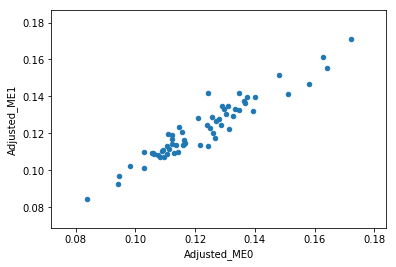

In [79]:
compare.loc[compare.N>500].plot.scatter('Adjusted_ME0', 'Adjusted_ME1')

In [92]:
compare = compare.sort_values('intercept')
compare = compare.assign(intercept_rank = range(len(compare)))

In [109]:
compare = compare.assign(Division_y = 'middle60')
compare.loc[compare.Rank_y<int(len(compare)*0.2), 'Division_y'] = 'top20'
compare.loc[compare.Rank_y>int(len(compare)*0.8), 'Division_y'] = 'bottom20'

In [149]:
recycle_ME_index = pd.read_csv(path+'cohorts/{}/recycled_ME.csv'.format(cohort))

In [150]:
recycle_ME_tst = pd.read_csv(path+'cohorts/{}/recycled_ME_tst0.csv'.format(cohort))

In [152]:
compare = pd.merge(recycle_ME_index, recycle_ME_tst, on='HOSP_NRD')

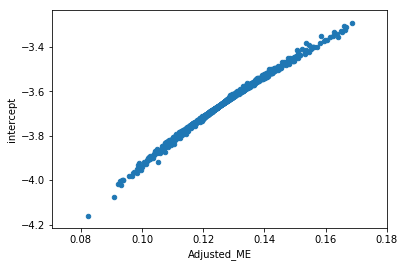

In [156]:
compare.plot.scatter('Adjusted_ME', 'intercept')

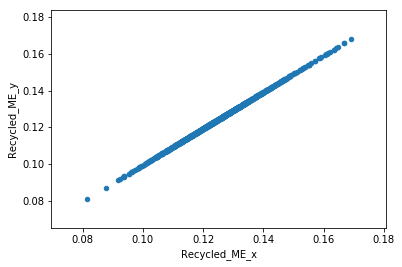

In [154]:
compare.plot.scatter('Recycled_ME_x', 'Recycled_ME_y')

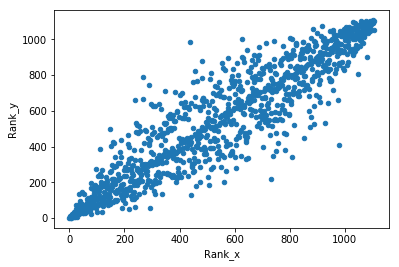

In [110]:
compare.plot.scatter('Rank_x', 'Rank_y')

In [111]:
pd.crosstab(compare.Division_x, compare.Division_y, margins=True)

Division_y,bottom20,middle60,top20,All
Division_x,,,,
bottom20,172,49,0,221
middle60,49,577,39,665
top20,0,39,182,221
All,221,665,221,1107


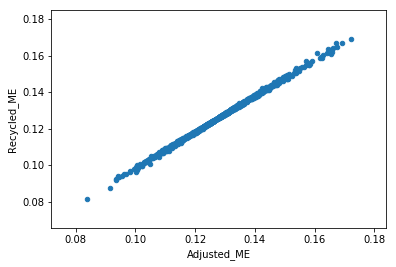

In [16]:
adjusted_rate.plot.scatter('Adjusted_ME', 'Recycled_ME')

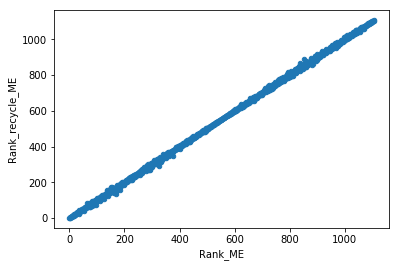

In [22]:
adjusted_rate.plot.scatter('Rank_ME', 'Rank_recycle_ME')

In [23]:
pd.crosstab(adjusted_rate.Division_ME, adjusted_rate.Division_recycle_ME, margins=True)

Division_recycle_ME,bottom20,middle60,top20,All
Division_ME,,,,
bottom20,216,5,0,221
middle60,5,655,5,665
top20,0,5,216,221
All,221,665,221,1107


## Risk Adjustment for DL

In [5]:
cohort='ami'
tst_seed=0

In [6]:
index_df = pd.read_csv(path+'cohorts/{}/index_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [70]:
index_df.shape

(191509, 183)

In [7]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

### Data formating

In [95]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing']+sorted(dx_multi.ICD9CM_CODE)*2+sorted(pr_multi.ICD9CM_CODE)+sorted(dx_ccs_cat)[1:]*2+sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                             1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))

In [8]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [9]:
hosp_freq = all_df.HOSP_NRD.value_counts()

In [12]:
len(hosp_freq), sum(hosp_freq>30)

(1107, 868)

In [97]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [98]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

In [99]:
DX1_array = index_df.DX1.map(DX1_dict).values
DX_df = index_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)
DX_mat = DX_df.values
PR_df = index_df[PRs]
PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)
PR_mat = PR_df.values
demo_mat = index_df[['AGE', 'FEMALE']].values
demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std
hosp_array = index_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat = to_categorical(index_df.PAY1.values)[:, 1:]
los_array = (index_df.LOS.values - los_mean)/los_std
ed_mat = to_categorical(index_df.HCUP_ED.values)
zipinc_mat = to_categorical(index_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat = to_categorical(index_df.SAMEDAYEVENT.values)
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), 
                                ed_mat, zipinc_mat, transfer_mat), axis=1)

### Model Building

In [100]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [101]:
code_embed_dim = 200
md_width = 128
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
batchsize = 512

In [103]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1, name='hosp_embed')(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
x = Dense(fc_width, activation='relu')(merged)
x = Dropout(dropout)(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [104]:
model.load_weights(model_path+'best_{}{}.h5'.format(cohort, tst_seed))

In [105]:
y = model.predict([DX1_array, DX_mat, PR_mat, hosp_array, other_mat], verbose=1)

y_pred = y[:, 1]

191509/191509 [==============================] - 10s 51us/step


In [109]:
national_pred = y_pred.mean()

In [106]:
y_true = adjust_df.readm30.values

{0: 0.732404492704879}

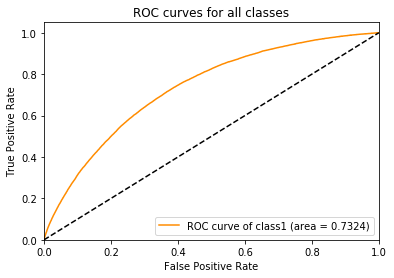

In [107]:
plot_roc(y_pred, y_true)

In [112]:
hosp_embed_layer = [l for l in model.layers if l.name=='hosp_embed'][0]

hosp_embed_mat = hosp_embed_layer.get_weights()[0]

hosp_embed_array = hosp_embed_mat[:, 0]

In [63]:
adjust_df = adjust_df.assign(predicted_score_dl=y_pred)

In [24]:
grouped = adjust_df.groupby('HOSP_NRD')

In [25]:
adjusted_rate = grouped[['readm30', 'predicted_score', 'expected_score', 'predicted_score_dl']].mean()

In [78]:
adjusted_rate = adjusted_rate.assign(N=grouped.size())

In [27]:
adjusted_rate = adjusted_rate.sort_values(by='N', ascending=False)

In [30]:
adjust_df.predicted_score_dl.mean(), adjust_df.readm30.mean(), adjust_df.predicted_score.mean()

(0.11953476071357727, 0.12666245450605454, 0.12489865147974813)

In [68]:
national_observed = adjust_df.readm30.mean()

In [36]:
adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'Predicted_DL', 'N']

In [100]:
adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'N']

In [101]:
adjusted_rate = adjusted_rate.assign(Adjusted_ME=adjusted_rate.Predicted_ME/adjusted_rate.Expected_ME*national_observed)

In [69]:
hosp_lst = adjusted_rate.HOSP_NRD.values

In [70]:
hosp_lst[:10]

array([12245, 13794, 13108, 11296, 11449, 12888, 11569, 11386, 12616,
       12419])

In [71]:
recycle_pred = []
for i, hosp in enumerate(hosp_lst[:5]):
    hosp_array = np.repeat(hosp_dict[hosp], len(index_df))
    y = model.predict([DX1_array, DX_mat, PR_mat, hosp_array, other_mat], verbose=0)
    y_pred = y[:, 1]
    recycle_pred.append(y_pred.mean())
    print(i)

0
1
2
3
4


In [72]:
recycle_pred

[0.12781878, 0.119579345, 0.12239194, 0.11557904, 0.11595199]

In [47]:
len(recycle_pred)

1107

In [48]:
adjusted_rate = adjusted_rate.assign(Adjusted_DL=recycle_pred)

In [17]:
adjusted_rate0 = adjusted_rate.copy()

In [10]:
adjusted_rate = adjusted_rate0.loc[adjusted_rate0.N>9]

In [18]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_ME')
adjusted_rate = adjusted_rate.assign(Rank_ME = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_ME = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_ME<int(len(adjusted_rate)*0.2), 'Division_ME'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_ME>int(len(adjusted_rate)*0.8), 'Division_ME'] = 'bottom20'

In [19]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_DL')
adjusted_rate = adjusted_rate.assign(Rank_DL = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_DL = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_DL<int(len(adjusted_rate)*0.2), 'Division_DL'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_DL>int(len(adjusted_rate)*0.8), 'Division_DL'] = 'bottom20'

In [20]:
adjusted_rate = adjusted_rate.sort_values('Recycled_ME')
adjusted_rate = adjusted_rate.assign(Rank_recycle_ME = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_recycle_ME = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_recycle_ME<int(len(adjusted_rate)*0.2), 'Division_recycle_ME'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_recycle_ME>int(len(adjusted_rate)*0.8), 'Division_recycle_ME'] = 'bottom20'

In [15]:
adjusted_rate.head(20)

,HOSP_NRD,Observed,Predicted_ME,Expected_ME,Predicted_DL,N,Adjusted_ME,Adjusted_DL,Rank_ME,Division_ME,Rank_DL,Division_DL
857,12513,0.000000,0.098073,0.107894,0.072570,34,0.115133,0.100217,164,top20,0,top20
420,14035,0.045714,0.087958,0.119099,0.084754,175,0.093544,0.101063,2,top20,1,top20
31,11058,0.061667,0.077574,0.104205,0.086588,600,0.094293,0.102124,5,top20,2,top20
269,13967,0.060241,0.092157,0.116396,0.090304,249,0.100285,0.103186,14,top20,3,top20
38,11055,0.095400,0.099371,0.119092,0.104955,587,0.105687,0.103320,38,top20,4,top20
862,13462,0.060606,0.129126,0.141223,0.117283,33,0.115813,0.103486,183,top20,5,top20
593,13008,0.071429,0.100246,0.115616,0.094118,112,0.109824,0.103912,78,top20,6,top20
734,11184,0.046154,0.097535,0.111969,0.080916,65,0.110334,0.103967,85,top20,7,top20
769,12861,0.054545,0.092059,0.097675,0.067970,55,0.119379,0.104242,262,middle60,8,top20
428,13906,0.057803,0.078413,0.094241,0.071936,173,0.105389,0.104713,36,top20,9,top20


In [11]:
adjusted_rate[['HOSP_NRD', 'N', 'Observed', 'Adjusted_ME', 'Adjusted_DL']].tail(20)

,HOSP_NRD,N,Observed,Adjusted_ME,Adjusted_DL
1087,11424,11,0.090909,0.121668,0.110919
1088,12274,11,0.363636,0.128576,0.122766
1089,11456,11,0.090909,0.126595,0.117963
1090,13071,11,0.272727,0.125964,0.117699
1091,12828,11,0.181818,0.128669,0.120154
1092,11997,10,0.000000,0.120680,0.115942
1093,12874,10,0.200000,0.128908,0.112815
1094,13318,10,0.100000,0.124979,0.113105
1095,12066,10,0.200000,0.128936,0.123382
1096,12218,10,0.100000,0.125914,0.120221


In [14]:
adjusted_rate.shape

(1107, 12)

In [20]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [25]:
reg = LinearRegression().fit(adjusted_rate.Adjusted_DL.values.reshape((len(adjusted_rate),1)), adjusted_rate.Adjusted_ME.values)

In [28]:
reg.score(adjusted_rate.Adjusted_DL.values.reshape((len(adjusted_rate),1)), adjusted_rate.Adjusted_ME.values)

0.46597785395872465

In [47]:
stats = adjusted_rate[['Adjusted_ME', 'Adjusted_DL']].describe()

In [39]:
stats = stats.transpose()

In [40]:
stats = stats.assign(IQR=stats['75%']-stats['25%'])

In [41]:
stats

,count,mean,std,min,25%,50%,75%,max,IQR
Adjusted_ME,1107.0,0.127151,0.012296,0.083672,0.120041,0.126519,0.133801,0.172212,0.013760
Adjusted_DL,1107.0,0.119030,0.005857,0.100217,0.115115,0.119223,0.122996,0.134095,0.007881
Observed,1107.0,0.141335,0.064344,0.000000,0.100000,0.130435,0.166667,0.444444,0.066667


In [44]:
national_rate

0.12666245450605454

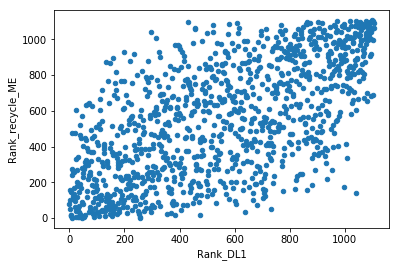

In [37]:
adjusted_rate.plot.scatter('Rank_DL1', 'Rank_recycle_ME')

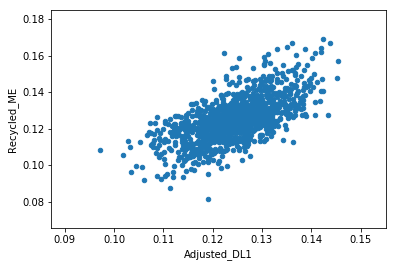

In [38]:
adjusted_rate.plot.scatter('Adjusted_DL1', 'Recycled_ME')

In [39]:
pd.crosstab(adjusted_rate.Division_DL1, adjusted_rate.Division_recycle_ME, margins=True)

Division_recycle_ME,bottom20,middle60,top20,All
Division_DL1,,,,
bottom20,116,103,2,221
middle60,103,456,106,665
top20,2,106,113,221
All,221,665,221,1107


In [18]:
pd.crosstab(adjusted_rate.Division_DL, adjusted_rate.Division_ME, normalize='index')

Division_ME,bottom20,middle60,top20
Division_DL,,,
bottom20,0.542986,0.443439,0.013575
middle60,0.148872,0.708271,0.142857
top20,0.009050,0.434389,0.556561


In [16]:
adjusted_rate = adjusted_rate.assign(rank_diff=adjusted_rate.Rank_ME - adjusted_rate.Rank_DL)

In [17]:
adjusted_rate.sort_values('rank_diff', ascending=False).head()

,HOSP_NRD,Observed,Predicted_ME,Expected_ME,Predicted_DL,N,Adjusted_ME,Adjusted_DL,Rank_ME,Division_ME,Rank_DL,Division_DL,rank_diff
301,13042,0.141026,0.133393,0.123684,0.130901,234,0.136605,0.112552,908,bottom20,151,top20,757
329,11973,0.150000,0.139472,0.130377,0.143659,220,0.135498,0.112926,876,middle60,169,top20,707
562,11943,0.139344,0.111421,0.103801,0.125417,122,0.135961,0.113867,891,bottom20,209,top20,682
213,13180,0.161972,0.135559,0.111793,0.127514,284,0.153590,0.116939,1074,bottom20,397,middle60,677
568,13408,0.159664,0.133056,0.117297,0.125535,119,0.143680,0.116379,1008,bottom20,362,middle60,646


In [50]:
adjusted_rate.to_csv(path+'cohorts/{}/adjusted_rate.csv'.format(cohort))

In [24]:
adjusted_rate = pd.read_csv(path+'cohorts/{}/adjusted_rate.csv'.format(cohort))

In [138]:
recycle_DL = pd.read_csv(path+'cohorts/{}/recyc_pred_{}.csv'.format(cohort, 0))
recycle_DL.columns = ['Adjusted_index{}'.format(0), 'HOSP_NRD']
for tst_seed in range(1, 10):
    recyc = pd.read_csv(path+'cohorts/{}/recyc_pred_{}.csv'.format(cohort, tst_seed))
    recyc.columns = ['Adjusted_index{}'.format(tst_seed), 'HOSP_NRD']
    recycle_DL = pd.merge(recycle_DL, recyc, on='HOSP_NRD')

In [139]:
for tst_seed in range(7):
    recyc = pd.read_csv(path+'cohorts/{}/recyc_pred_tst{}.csv'.format(cohort, tst_seed))
    recyc.columns = ['Adjusted_tst{}'.format(tst_seed), 'HOSP_NRD']
    recycle_DL = pd.merge(recycle_DL, recyc, on='HOSP_NRD')

In [80]:
recycle_DL = recycle_DL.assign(mean=recycle_DL[['Adjusted_DL'+str(s) for s in range(10)]].mean(axis=1))
recycle_DL = recycle_DL.assign(std=recycle_DL[['Adjusted_DL'+str(s) for s in range(10)]].std(axis=1)/np.sqrt(1))
recycle_DL = recycle_DL.assign(upper=recycle_DL['mean']+1.96*recycle_DL['std'])
recycle_DL = recycle_DL.assign(lower=recycle_DL['mean']-1.96*recycle_DL['std'])

In [140]:
recycle_DL.head()

,Adjusted_index0,HOSP_NRD,Adjusted_index1,Adjusted_index2,Adjusted_index3,Adjusted_index4,Adjusted_index5,Adjusted_index6,Adjusted_index7,Adjusted_index8,Adjusted_index9,Adjusted_tst0,Adjusted_tst1,Adjusted_tst2,Adjusted_tst3,Adjusted_tst4,Adjusted_tst5,Adjusted_tst6
0,0.111387,11006.0,0.117523,0.120643,0.106672,0.118943,0.125235,0.127023,0.108597,0.106732,0.119385,0.110114,0.115654,0.120461,0.105349,0.117297,0.123791,0.125217
1,0.115136,11010.0,0.118052,0.119817,0.109564,0.117154,0.109042,0.123234,0.104473,0.097824,0.110803,0.113841,0.116177,0.119639,0.108220,0.115513,0.107679,0.121456
2,0.111795,11011.0,0.108583,0.125113,0.110101,0.115699,0.118537,0.115928,0.107616,0.103374,0.111845,0.110519,0.106824,0.124908,0.108752,0.114063,0.117123,0.114209
3,0.128108,11013.0,0.133123,0.137423,0.132450,0.137320,0.127113,0.141172,0.133023,0.146313,0.130289,0.126742,0.131081,0.137156,0.130943,0.135636,0.125661,0.139268
4,0.115302,11014.0,0.126566,0.117974,0.112363,0.114952,0.115864,0.129919,0.115519,0.114341,0.115896,0.114006,0.124595,0.117805,0.110998,0.113317,0.114464,0.128092


In [119]:
recycle_DL = recycle_DL.assign(intercept0=recycle_DL.HOSP_NRD.apply(lambda x:hosp_embed_array[hosp_dict[x]]))

In [22]:
recycle_DL.upper.min(), recycle_DL.lower.max()

(0.10371397972452481, 0.1361400854459275)

In [110]:
sum(recycle_DL.upper<national_pred), sum(recycle_DL.lower>national_pred)

(21, 28)

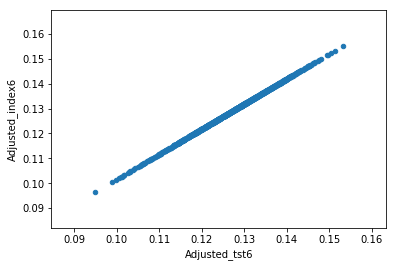

In [146]:
recycle_DL.plot.scatter('Adjusted_tst6', 'Adjusted_index6')

In [141]:
compare = pd.merge(adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], recycle_DL[['HOSP_NRD', 'mean']], on='HOSP_NRD')

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: FutureWarning: 'HOSP_NRD' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


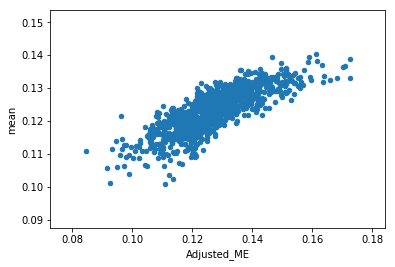

In [142]:
compare.plot.scatter('Adjusted_ME', 'mean')

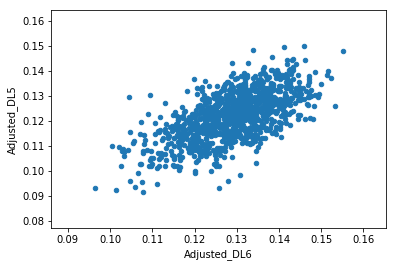

In [124]:
recycle_DL.plot.scatter('Adjusted_DL6', 'Adjusted_DL5')

In [31]:
adjusted_rate = pd.merge(adjusted_rate, recycle_DL1, on='HOSP_NRD')

In [32]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_DL1')
adjusted_rate = adjusted_rate.assign(Rank_DL1 = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_DL1 = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_DL1<int(len(adjusted_rate)*0.2), 'Division_DL1'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_DL1>int(len(adjusted_rate)*0.8), 'Division_DL1'] = 'bottom20'

In [41]:
adjusted_rate[['Adjusted_DL', 'Adjusted_DL1']].describe()

,Adjusted_DL,Adjusted_DL1
count,1107.000000,1107.000000
mean,0.119030,0.124436
std,0.005857,0.007482
min,0.100217,0.097055
25%,0.115115,0.119554
50%,0.119223,0.124456
75%,0.122996,0.129663
max,0.134095,0.145435


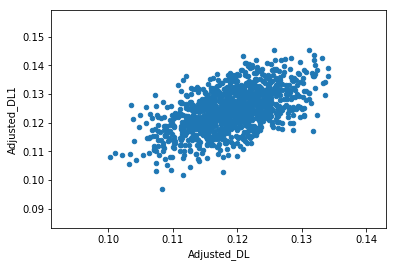

In [33]:
adjusted_rate.plot.scatter('Adjusted_DL', 'Adjusted_DL1')

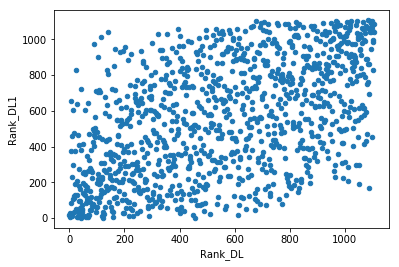

In [34]:
adjusted_rate.plot.scatter('Rank_DL', 'Rank_DL1')

In [36]:
pd.crosstab(adjusted_rate.Division_DL, adjusted_rate.Division_DL1, margins=True)

Division_DL1,bottom20,middle60,top20,All
Division_DL,,,,
bottom20,95,123,3,221
middle60,118,434,113,665
top20,8,108,105,221
All,221,665,221,1107


In [57]:
pd.DataFrame(dict(HOSP_NRD=hosp_cat, ids=range(len(hosp_cat))))

,HOSP_NRD,ids
0,11006.0,0
1,11010.0,1
2,11011.0,2
3,11013.0,3
4,11014.0,4
5,11021.0,5
6,11022.0,6
7,11024.0,7
8,11029.0,8
9,11032.0,9


## Diagnosis for abnormal hospitals

In [18]:
hosp1 = index_df.loc[index_df.HOSP_NRD==13042]

In [20]:
comorbs = [c for c in index_df.columns if c.startswith('CM_')]

In [33]:
pd.concat([hosp1[comorbs].mean(), index_df[comorbs].mean()], axis=1)

,0,1
CM_AIDS,0.000000,0.001426
CM_ALCOHOL,0.072650,0.035330
CM_ANEMDEF,0.196581,0.165893
CM_ARTH,0.029915,0.026025
CM_BLDLOSS,0.000000,0.007185
CM_CHF,0.008547,0.004741
CM_CHRNLUNG,0.205128,0.205108
CM_COAG,0.025641,0.054447
CM_DEPRESS,0.085470,0.081098
CM_DM,0.388889,0.298633


In [38]:
cooccur_hosp1 = np.dot(hosp1[comorbs].values.transpose(), hosp1[comorbs].values)/len(hosp1)

In [42]:
cooccur_index = np.dot(index_df[comorbs].values.transpose(), index_df[comorbs].values)/len(index_df)

In [43]:
diff = pd.DataFrame(data=(cooccur_hosp1-cooccur_index), index=comorbs, columns=comorbs)

In [50]:
np.where(diff.values==diff.values.max())

(array([9]), array([9]))

In [52]:
cooccur_hosp1[9, 12]

0.32051282051282054

In [53]:
cooccur_index[9, 12]

0.24922588494535505

In [51]:
diff

,CM_AIDS,CM_ALCOHOL,CM_ANEMDEF,CM_ARTH,CM_BLDLOSS,CM_CHF,CM_CHRNLUNG,CM_COAG,CM_DEPRESS,CM_DM,...,CM_OBESE,CM_PARA,CM_PERIVASC,CM_PSYCH,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS
CM_AIDS,-0.001426,-0.000089,-0.000324,-0.000031,-0.000005,-0.000010,-0.000266,-0.000131,-0.000251,-0.000355,...,-0.000094,-0.000021,-0.000120,-0.000099,-0.000005,-0.000355,-0.000021,0.000000,-0.000005,-0.000057
CM_ALCOHOL,-0.000089,0.037320,0.011925,-0.000486,-0.000240,-0.000198,0.016028,-0.003415,0.009416,0.010013,...,0.003096,-0.000407,0.004041,0.002263,-0.000042,0.004730,-0.000428,-0.000021,-0.000052,0.002702
CM_ANEMDEF,-0.000324,0.011925,0.030688,0.002469,-0.001493,-0.001551,-0.002312,-0.018025,0.000520,0.046577,...,-0.002431,-0.000478,-0.013127,-0.006099,-0.000366,0.012402,-0.004099,-0.000141,-0.000574,0.006739
CM_ARTH,-0.000031,-0.000486,0.002469,0.003890,-0.000277,-0.000073,-0.007227,-0.001828,0.001177,0.018889,...,0.004297,-0.000418,0.000409,-0.000841,-0.000031,0.006544,-0.000433,-0.000016,-0.000031,-0.001159
CM_BLDLOSS,-0.000005,-0.000240,-0.001493,-0.000277,-0.007185,-0.000131,-0.002104,-0.000893,-0.000689,-0.002334,...,-0.001269,-0.000178,-0.001650,-0.000219,-0.000010,-0.002882,-0.000334,-0.000016,-0.000057,-0.000512
CM_CHF,-0.000010,-0.000198,-0.001551,-0.000073,-0.000131,0.003806,-0.001316,0.003532,-0.000345,-0.001478,...,-0.000862,-0.000319,-0.000966,-0.000157,-0.000595,0.006563,-0.000183,0.000000,-0.001050,-0.000877
CM_CHRNLUNG,-0.000266,0.016028,-0.002312,-0.007227,-0.002104,-0.001316,0.000020,-0.009240,0.001209,0.015111,...,0.000873,-0.003911,-0.007136,0.003912,-0.000334,-0.009325,-0.004705,-0.000078,-0.000423,-0.004269
CM_COAG,-0.000131,-0.003415,-0.018025,-0.001828,-0.000893,0.003532,-0.009240,-0.028806,-0.000222,-0.003529,...,-0.001087,-0.001342,-0.010454,-0.001723,-0.000157,-0.013214,-0.001201,-0.000021,-0.000345,-0.003781
CM_DEPRESS,-0.000251,0.009416,0.000520,0.001177,-0.000689,-0.000345,0.001209,-0.000222,0.004372,0.009119,...,-0.004735,-0.002047,-0.003050,0.002263,-0.000073,0.007997,-0.001206,-0.000010,-0.000146,0.001449
CM_DM,-0.000355,0.010013,0.046577,0.018889,-0.002334,-0.001478,0.015111,-0.003529,0.009119,0.090255,...,0.022665,-0.001643,0.017427,0.000620,-0.000282,0.027662,-0.004261,-0.000094,-0.000496,-0.006433
